# Movie Data Analysis and Recommender System

![](https://media.giphy.com/media/3ohhwDMC187JqL69DG/giphy.gif)

The birth of the Motion Picture Camera in the late 18th century gave birth to possibly the most potent form of entertainment in existence: Cinema. Movies have managed to enthrall audiences ever since one second clips of racing horses emerged in the 1890s to the introduction of sound in the 1920s to the birth of color in the 1930s to mainstream 3D Movies in the early 2010s.

Cinema had humble origins in terms of plot, direction and acting (mainly due to its extremely short duration in its early days) but since then, movie industries around the world have been blessed with creative geniuses in the form of directors, screenwriters, actors, sound designers and cinematographers. It has also spread itself into a plethora of genres ranging from romance to comedy to science fiction to horror.

As with almost every kid born in the last century, I was amazed by movies. I was addicted to it. And I've always wanted to know more about the enigmatic world of cinema. In this notebook, I will try and gain some insights using data. With us, we have a dataset of about 45000 movies with metadata collected from TMDB. Using this data, we will try and answer various questions that I've always had about movies. 

I will also try and build the following:
* A **Regressor** that can, to a certain degree, predict the revenue of a particular movie.
* A **Classifier** that identifies if a movie will be a hit or will make the producers lose money.
* A **Hybrid Recommendation System** based on popularity, content and collaborative filtering. This will use the MovieLens dataset in addition to the TMDB Movies Metadata.

## Importing Libraries and Loading Our Data

In [1]:
%matplotlib inline
from IPython.display import Image, HTML
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from wordcloud import WordCloud, STOPWORDS
import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='rounakbanik', api_key='xTLaHBy9MVv5szF4Pwan')

sns.set_style('whitegrid')
pd.set_option('display.max_colwidth', 50)

In [2]:
df = pd.read_csv('data/movies_metadata.csv')
df.head()

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


## Understanding the Dataset

The dataset above was obtained through the TMDB API. The movies available in this dataset are in correspondence with the movies that are listed in the **MovieLens Latest Full Dataset** comprising of 26 million ratings on 45,000 movies from 27,000 users. Let us have a look at the features that are available to us.

In [3]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

### Features

* **adult:** Indicates if the movie is X-Rated or Adult.
* **belongs_to_collection:** A stringified dictionary that gives information on the movie series the particular film belongs to.
* **budget:** The budget of the movie in dollars.
* **genres:** A stringified list of dictionaries that list out all the genres associated with the movie.
* **homepage:** The Official Homepage of the move.
* **id:** The ID of the move.
* **imdb_id:** The IMDB ID of the movie.
* **original_language:** The language in which the movie was originally shot in.
* **original_title:** The original title of the movie.
* **overview:** A brief blurb of the movie.
* **popularity:** The Popularity Score assigned by TMDB.
* **poster_path:** The URL of the poster image.
* **production_companies:** A stringified list of production companies involved with the making of the movie.
* **production_countries:** A stringified list of countries where the movie was shot/produced in.
* **release_date:** Theatrical Release Date of the movie.
* **revenue:** The total revenue of the movie in dollars.
* **runtime:** The runtime of the movie in minutes.
* **spoken_languages:** A stringified list of spoken languages in the film.
* **status:** The status of the movie (Released, To Be Released, Announced, etc.)
* **tagline:** The tagline of the movie.
* **title:** The Official Title of the movie.
* **video:** Indicates if there is a video present of the movie with TMDB.
* **vote_average:** The average rating of the movie.
* **vote_count:** The number of votes by users, as counted by TMDB.

In [4]:
df.shape

(45466, 24)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null float64
runtime                  45203 non-null float64
spoken_languages         45460 non-null object
status                   45379 non-null objec

There are a total of **45,466 movies** with **24 features**. Most of the features have very few NaN values (apart from **homepage** and **tagline**). We will attempt at cleaning this dataset to a form suitable for analysis in the next section.

## Data Wrangling

The data that was originally obtained was in the form of a JSON File. This was converted manually into a CSV file to arrive at an input that could be loaded into a Pandas DataFrame effortlessly. In other words, the dataset we have in our hands is already relatively clean. We will however attempt at learning more about our features and performing appropriate wrangling steps to arrive at a form that is more suitable for analysis.

Let us start by removing the features that are not useful to us.

In [6]:
df = df.drop(['imdb_id'], axis=1)

In [7]:
df[df['original_title'] != df['title']][['title', 'original_title']].head()

,title,original_title
28,The City of Lost Children,La Cité des Enfants Perdus
29,Shanghai Triad,摇啊摇，摇到外婆桥
32,Wings of Courage,"Guillaumet, les ailes du courage"
57,The Postman,Il postino
58,The Confessional,Le confessionnal


The original title refers to the title of the movie in the native language in which the movie was shot. As such, I will prefer using the translated, Anglicized name in this analysis and hence, will drop the original titles altogether. We will be able to deduce if the movie is a foreign language film by looking at the **original_language** feature so no tangible information is lost in doing so.

In [8]:
df = df.drop('original_title', axis=1)

In [9]:
df[df['revenue'] == 0].shape

(38052, 22)

We see that the majority of the movies have a recorded revenue of **0**. This indicates that we do not have information about the total revenue for these movies. Although this forms the majority of the movies available to us, we will still use revenue as an extremely important feature going forward from the remaining 7000 moves.

In [10]:
df['revenue'] = df['revenue'].replace(0, np.nan)

The **budget** feature has some unclean values that makes Pandas assign it as a generic object. We proceed to convert this into a numeric variable and replace all the non-numeric values with NaN. Finally, as with budget, we will convert all the values of 0 with NaN to indicate the absence of information regarding budget.

In [11]:
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['budget'] = df['budget'].replace(0, np.nan)
df[df['budget'].isnull()].shape

(36576, 22)

As we move forward trying to answer certain questions, we will have to construct several features suitable for that particular query. For now, we will construct two very important features:
* **year:** The year in which the movie was released.
* **return:** The ratio of revenue to budget.

The **return** feature is extremely insightful as it will give us a more accurate picture of the financial success of a movie. Presently, our data will not be able to judge if a \$200 million budget movie that earned \$100 million did better than a \$50,000 budget movie taking in \$200,000. This feature will be able to capture that information.

A return value > 1 would indicate profit whereas a return value < 1 would indicate a loss.

In [12]:
df['return'] = df['revenue'] / df['budget']
df[df['return'].isnull()].shape

(40085, 23)

We have close to **5000 movies** for which we have data on revenue and budget ratio. This is close to **10% of the entire dataset**. Although this may seem small, this is enough to perform very useful analysis and discover interesting insights about the world of movies.

In [13]:
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [14]:
df['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
 - Written by Ørnås                                                                                                                   1
Name: adult, dtype: int64

There are close to **0 adult movies** in this dataset. The **adult** feature therefore is not of much use to us and can be safely dropped.

In [15]:
df = df.drop('adult', axis=1)

In [16]:
base_poster_url = 'http://image.tmdb.org/t/p/w185/'
df['poster_path'] = "<img src='" + base_poster_url + df['poster_path'] + "' style='height:100px;'>"

## Exploratory Data Analysis
### Title and Overview Wordclouds

Are there certain words that figure more often in Movie Titles and Movie Blurbs? I suspect there are some words which are considered more potent and considered more worthy of a title. Let us find out!

In [17]:
df['title'] = df['title'].astype('str')
df['overview'] = df['overview'].astype('str')

In [18]:
title_corpus = ' '.join(df['title'])
overview_corpus = ' '.join(df['overview'])

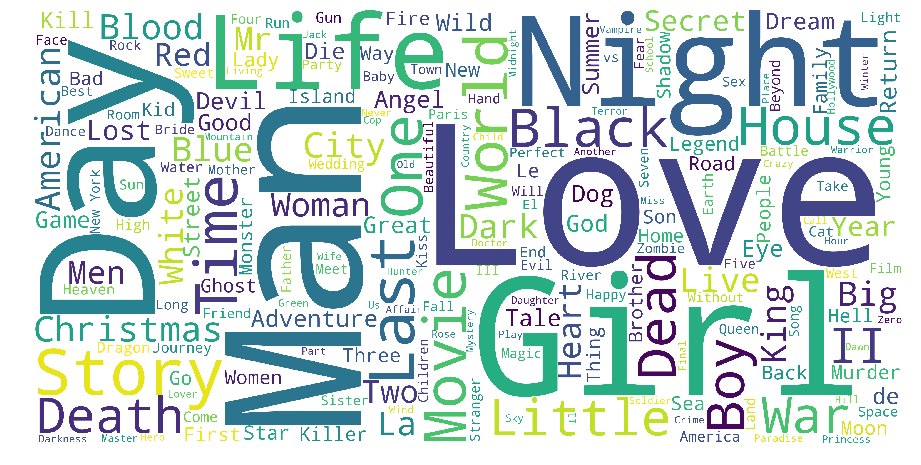

In [19]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

The word **Love** is the most commonly used word in movie titles. **Girl**, **Day** and **Man** are also among the most commonly occuring words. I think this encapsulates the idea of the ubiquitious presence of romance in movies pretty well.

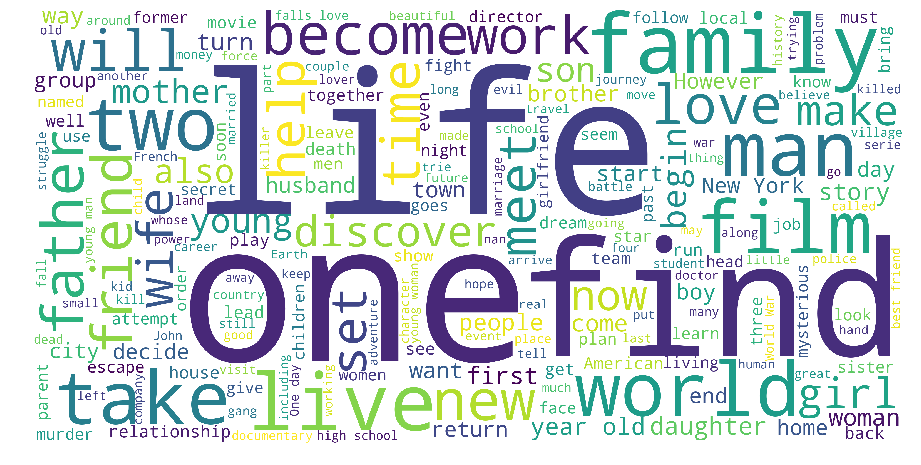

In [20]:
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

**Life** is the most commonly used word in Movie titles. **One** and **Find** are also popular in Movie Blurbs. Together with **Love**, **Man** and **Girl**, these wordclouds give us a pretty good idea of the most popular themes present in movies. 

### Production Countries

The Full MovieLens Dataset consists of movies that are overwhelmingly in the English language (more than 31000). However, these movies may have shot in various locations around the world. It would be interesting to see which countries serve as the most popular destinations for shooting movies by filmmakers, especially those in the United States of America and the United Kingdom.

In [21]:
df['production_countries'] = df['production_countries'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [22]:
s = df.apply(lambda x: pd.Series(x['production_countries']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'countries'

In [23]:
con_df = df.drop('production_countries', axis=1).join(s)
con_df = pd.DataFrame(con_df['countries'].value_counts())
con_df['country'] = con_df.index
con_df.columns = ['num_movies', 'country']
con_df = con_df.reset_index().drop('index', axis=1)
con_df.head(10)

,num_movies,country
0,21153,United States of America
1,4094,United Kingdom
2,3940,France
3,2254,Germany
4,2169,Italy
5,1765,Canada
6,1648,Japan
7,964,Spain
8,912,Russia
9,828,India


In [24]:
con_df = con_df[con_df['country'] != 'United States of America']

In [25]:
data = [ dict(
        type = 'choropleth',
        locations = con_df['country'],
        locationmode = 'country names',
        z = con_df['num_movies'],
        text = con_df['country'],
        colorscale = [[0,'rgb(255, 255, 255)'],[1,'rgb(255, 0, 0)']],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Production Countries'),
      ) ]

layout = dict(
    title = 'Production Countries for the MovieLens Movies (Apart from US)',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~rounakbanik/0 or inside your plot.ly account where it is named 'd3-world-map'


Unsurprisingly, the **United States** is the most popular destination of production for movies given that our dataset largely consists of English movies. **Europe** is also an extremely popular location with the UK, France, Germany and Italy in the top 5. **Japan** and **India** are the most popular Asian countries when it comes to movie production.

### Franchise Movies

Let us now have a brief look at Franchise movies. I was curious to discover the longest running and the most successful franchises among many other things. Let us wrangle our data to find out!

In [26]:
df_fran = df[df['belongs_to_collection'].notnull()]
df_fran['belongs_to_collection'] = df_fran['belongs_to_collection'].apply(ast.literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)
df_fran = df_fran[df_fran['belongs_to_collection'].notnull()]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [27]:
fran_sum = pd.DataFrame(df_fran.groupby('belongs_to_collection')['revenue'].sum().sort_values(ascending=False))
fran_sum.columns = ['Total']
fran_mean = pd.DataFrame(df_fran.groupby('belongs_to_collection')['revenue'].mean().sort_values(ascending=False))
fran_mean.columns = ['Average']
fran_count = pd.DataFrame(df_fran.groupby('belongs_to_collection')['revenue'].count().sort_values(ascending=False))
fran_count.columns = ['Number']

fran_pivot = pd.concat((fran_sum, fran_mean, fran_count), axis=1)

#### Highest Grossing Movie Franchises 

In [28]:
fran_pivot.sort_values('Total', ascending=False).head(10)

,Total,Average,Number
Harry Potter Collection,7.707367e+09,9.634209e+08,8
Star Wars Collection,7.434495e+09,9.293118e+08,8
James Bond Collection,7.106970e+09,2.733450e+08,26
The Fast and the Furious Collection,5.125099e+09,6.406373e+08,8
Pirates of the Caribbean Collection,4.521577e+09,9.043154e+08,5
Transformers Collection,4.366101e+09,8.732202e+08,5
Despicable Me Collection,3.691070e+09,9.227676e+08,4
The Twilight Collection,3.342107e+09,6.684215e+08,5
Ice Age Collection,3.216709e+09,6.433417e+08,5
Jurassic Park Collection,3.031484e+09,7.578710e+08,4


The **Harry Potter** Franchise is the most successful movie franchise raking in more than 7.707 billion dollars from 8 movies. The **Star Wars** Movies come in a close second with a 7.403 billion dollars from 8 movies too. **James Bond**
is third but the franchise has significantly more movies compared to the others in the list and therefore, a much smaller average gross.

#### Most Successful Movie Franchises (by Average Gross)

We will use the average gross per movie to gauge the success of a movie franchise. However, this is not a very potent metric as the revenues in this dataset have not been adjusted for inflation. Therefore, revenue statistics will tend to strongly favor franchises in the recent times.

In [29]:
fran_pivot.sort_values('Average', ascending=False).head(10)

,Total,Average,Number
Avatar Collection,2.787965e+09,2.787965e+09,1
The Avengers Collection,2.924962e+09,1.462481e+09,2
Frozen Collection,1.274219e+09,1.274219e+09,1
Finding Nemo Collection,1.968906e+09,9.844532e+08,2
The Hobbit Collection,2.935523e+09,9.785078e+08,3
The Lord of the Rings Collection,2.916545e+09,9.721816e+08,3
Harry Potter Collection,7.707367e+09,9.634209e+08,8
Star Wars Collection,7.434495e+09,9.293118e+08,8
Despicable Me Collection,3.691070e+09,9.227676e+08,4
Pirates of the Caribbean Collection,4.521577e+09,9.043154e+08,5


The **Avatar** Collection, although just consisting of one movie at the moment, is the most successful franchise of all time with the sole movie raking in close to 3 billion dollars. The **Harry Potter** franchise is still the most successful franchise with at least 5 movies.

#### Longest Running Franchises

Finally, in this subsection, let us take a look at the franchises which have stood the test of time and have managed to deliver the largest number of movies under a single banner. This metric is potent in the way that it isn't affected by inflation. However, this does not imply that successful movie franchises tend to have more movies. Some franchises, such as Harry Potter, have a predefined storyline and it wouldn't make sense to produce more movies despite its enormous success.

In [30]:
fran_pivot.sort_values('Number', ascending=False).head(10)

,Total,Average,Number
James Bond Collection,7.106970e+09,2.733450e+08,26
Friday the 13th Collection,4.648985e+08,3.874155e+07,12
Pokémon Collection,6.983008e+08,6.348189e+07,11
Harry Potter Collection,7.707367e+09,9.634209e+08,8
Halloween Collection,2.471681e+08,3.089601e+07,8
A Nightmare on Elm Street Collection,3.635916e+08,4.544894e+07,8
The Fast and the Furious Collection,5.125099e+09,6.406373e+08,8
The Pink Panther (Original) Collection,1.644782e+08,2.055978e+07,8
Star Wars Collection,7.434495e+09,9.293118e+08,8
Police Academy Collection,3.046432e+08,4.352046e+07,7


The **James Bond** Movies is the largest franchise ever with over 26 movies released under the banner. **Friday the 13th** and **Pokemon** come in at a distant second and third with 12 and 11 movies respectively.

### Production Companies

In [31]:
df['production_companies'] = df['production_companies'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [32]:
s = df.apply(lambda x: pd.Series(x['production_companies']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'companies'

In [33]:
com_df = df.drop('production_companies', axis=1).join(s)

In [34]:
com_sum = pd.DataFrame(com_df.groupby('companies')['revenue'].sum().sort_values(ascending=False))
com_sum.columns = ['Total']
com_mean = pd.DataFrame(com_df.groupby('companies')['revenue'].mean().sort_values(ascending=False))
com_mean.columns = ['Average']
com_count = pd.DataFrame(com_df.groupby('companies')['revenue'].count().sort_values(ascending=False))
com_count.columns = ['Number']

com_pivot = pd.concat((com_sum, com_mean, com_count), axis=1)

#### Highest Earning Production Companies

Let us find out which production companies have earned the most money from the movie making business.

In [35]:
com_pivot.sort_values('Total', ascending=False).head(10)

,Total,Average,Number
Warner Bros.,6.352519e+10,1.293792e+08,491
Universal Pictures,5.525919e+10,1.193503e+08,463
Paramount Pictures,4.880819e+10,1.235650e+08,395
Twentieth Century Fox Film Corporation,4.768775e+10,1.398468e+08,341
Walt Disney Pictures,4.083727e+10,2.778046e+08,147
Columbia Pictures,3.227974e+10,1.367785e+08,236
New Line Cinema,2.217339e+10,1.119868e+08,198
Amblin Entertainment,1.734372e+10,2.550547e+08,68
DreamWorks SKG,1.547575e+10,1.984071e+08,78
Dune Entertainment,1.500379e+10,2.419966e+08,62


**Warner Bros** is the highest earning production company of all time earning a staggering 63.5 billion dollars from close to 500 movies. **Universal Pictures** and **Paramaount Pictures** are the second and the third highest earning companies with 55 billion dollars and 48 billion dollars in revenue respectively. 

#### Most Succesful Production Companies

Which production companies produce the most succesful movies on average? Let us find out. We will only consider those companies that have made at least 15 movies.

In [36]:
com_pivot[com_pivot['Number'] >= 15].sort_values('Average', ascending=False).head(10)

,Total,Average,Number
Pixar Animation Studios,1.118853e+10,6.215852e+08,18
Marvel Studios,1.169964e+10,6.157703e+08,19
Revolution Sun Studios,8.120339e+09,5.413559e+08,15
Lucasfilm,9.898421e+09,4.499282e+08,22
DreamWorks Animation,1.370752e+10,4.031622e+08,34
DC Entertainment,6.212609e+09,3.882880e+08,16
Dentsu,6.853205e+09,3.807336e+08,18
Jerry Bruckheimer Films,8.957441e+09,3.732267e+08,24
Marvel Enterprises,6.538067e+09,3.441088e+08,19
Legendary Pictures,1.346866e+10,3.367166e+08,40


**Pixar Animation Studios** has produced the most successful movies, on average. This is not surprising considering the amazing array of movies that it has produced in the last few decades: Up, Finding Nemo, Inside Out, Wall-E, Ratatouille, the Toy Story Franchise, Cars Franchise, etc. **Marvel Studios** with an average gross of 615 million dollars comes in second with movies such as Iron Man and The Avengers under its banner.

### Original Language

In this section, let us look at the languages of the movies in our dataset. From the production countries, we have already deduced that the majority of the movies in the dataset are English. Let us see what the other major languages represented are.

In [37]:
df['original_language'].drop_duplicates().shape[0]

93

In [38]:
lang_df = pd.DataFrame(df['original_language'].value_counts())
lang_df['language'] = lang_df.index
lang_df.columns = ['number', 'language']
lang_df.head()

,number,language
en,32269,en
fr,2438,fr
it,1529,it
ja,1350,ja
de,1080,de


There are over 93 languages represented in our dataset. As we had expected, English language films form the overwhelmingly majority. French and Italian movies come at a very distant second and third respectively. Let us represent the most popular languages (apart from English) in the form of a bar plot.

/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead



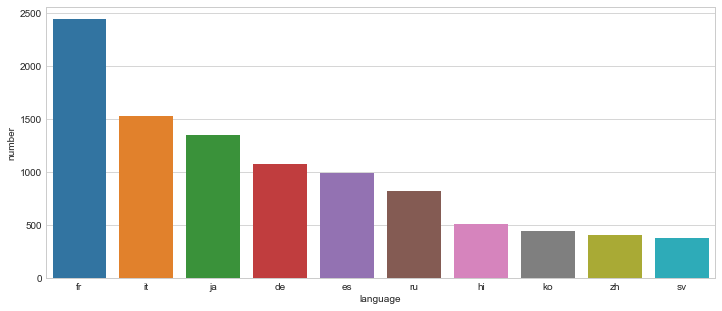

In [39]:
plt.figure(figsize=(12,5))
sns.barplot(x='language', y='number', data=lang_df.iloc[1:11])
plt.show()

As mentioned earlier, **French** and **Italian** are the most commonly occuring languages after English. **Japanese** and **Hindi** form the majority as far as Asian Languages are concerned.

### Popularity, Vote Average and Vote Count

In this section, we will work with metrics provided to us by TMDB users. We will try to gain a deeper understanding of the popularity, vote average and vote count features and try and deduce any relationships between them as well as other numeric features such as budget and revenue.

In [40]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [41]:
df['popularity'] = df['popularity'].apply(clean_numeric).astype('float')
df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float')

Let us examine the summary statistics and the distribution of each feature one by one.

In [42]:
df['popularity'].describe()

count    45460.000000
mean         2.921478
std          6.005414
min          0.000000
25%          0.385948
50%          1.127685
75%          3.678902
max        547.488298
Name: popularity, dtype: float64

/usr/local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning:

object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.



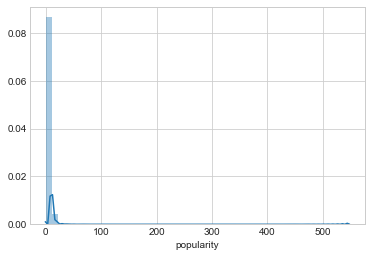

In [43]:
sns.distplot(df['popularity'].fillna(df['popularity'].median()))
plt.show()

The Popularity score seems to be an extremely skewed quentity with a mean of only **2.9** but maximum values reaching as high as 547, which is almost 1800% greater than the mean. However, as can be seen from the distribution plot, almost all movies have a popularity score less than 10 (the 75th percentile is at 3.678902).

#### Most Popular Movies by Popularity Score

In [44]:
df[['title', 'popularity', 'year']].sort_values('popularity', ascending=False).head(10)

,title,popularity,year
30700,Minions,547.488298,2015
33356,Wonder Woman,294.337037,2017
42222,Beauty and the Beast,287.253654,2017
43644,Baby Driver,228.032744,2017
24455,Big Hero 6,213.849907,2014
26564,Deadpool,187.860492,2016
26566,Guardians of the Galaxy Vol. 2,185.330992,2017
14551,Avatar,185.070892,2009
24351,John Wick,183.870374,2014
23675,Gone Girl,154.801009,2014


**Minions** is the most popular movie by the TMDB Popularity Score. **Wonder Woman** and **Beauty and the Beast**, two extremely succesful woman centric movies come in second and third respectively.

In [45]:
df['vote_count'].describe()

count    45460.000000
mean       109.897338
std        491.310374
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

As with popularity scores, the distribution of vote counts is extremely skewed with the median vote count standing at a paltry 10 votes. The most votes a single movie has got stands at 14,075. TMDB Votes, therefore, are not as potent and suggestive as its IMDB Counterpart. Nevertheless, let us check which the most voted on movies on the website are.

#### Most Voted on Movies

In [46]:
df[['title', 'vote_count', 'year']].sort_values('vote_count', ascending=False).head(10)

,title,vote_count,year
15480,Inception,14075.0,2010
12481,The Dark Knight,12269.0,2008
14551,Avatar,12114.0,2009
17818,The Avengers,12000.0,2012
26564,Deadpool,11444.0,2016
22879,Interstellar,11187.0,2014
20051,Django Unchained,10297.0,2012
23753,Guardians of the Galaxy,10014.0,2014
2843,Fight Club,9678.0,1999
18244,The Hunger Games,9634.0,2012


**Inception** and **The Dark Knight**, two critically acclaimed and commerically successful Christopher Nolan movies figure at the top of our chart. 

In [47]:
df['vote_average'] = df['vote_average'].replace(0, np.nan)
df['vote_average'].describe()

count    42462.000000
mean         6.014877
std          1.256208
min          0.500000
25%          5.300000
50%          6.100000
75%          6.900000
max         10.000000
Name: vote_average, dtype: float64

/usr/local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning:

object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.



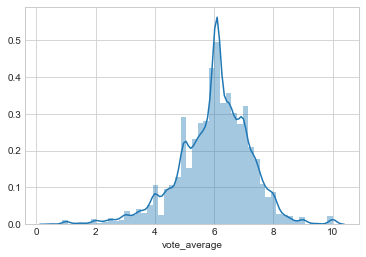

In [48]:
sns.distplot(df['vote_average'].fillna(df['vote_average'].median()))

It appears that TMDB Users are extremely strict in their ratings. The mean rating is only a **5.6** on a scale of 10. Half the movies have a rating of less than or equal to 6. Let us check what the most critically acclaimed movies as per TMDB are. We will only consider those movies that have more than 2000 votes (similar to IMDB's criteria of 5000 votes in selecting its top 250).

#### Most Critically Acclaimed Movies

In [49]:
df[df['vote_count'] > 2000][['title', 'vote_average', 'vote_count' ,'year']].sort_values('vote_average', ascending=False).head(10)

,title,vote_average,vote_count,year
314,The Shawshank Redemption,8.5,8358.0,1994
834,The Godfather,8.5,6024.0,1972
2211,Life Is Beautiful,8.3,3643.0,1997
5481,Spirited Away,8.3,3968.0,2001
1152,One Flew Over the Cuckoo's Nest,8.3,3001.0,1975
1176,Psycho,8.3,2405.0,1960
2843,Fight Club,8.3,9678.0,1999
1178,The Godfather: Part II,8.3,3418.0,1974
12481,The Dark Knight,8.3,12269.0,2008
292,Pulp Fiction,8.3,8670.0,1994


**The Shawshank Redemption** and **The Godfather** are the two most critically acclaimed movies in the TMDB Database. Interestingly, they are the top 2 movies in IMDB's Top 250 Movies list too. They have a rating of over 9 on IMDB as compared to their 8.5 TMDB Scores.

Do popularity and vote average share a tangible relationship? In other words, is there a strong positive correlation between these two quanitties? Let us visualise their relationship in the form of a scatterplot.

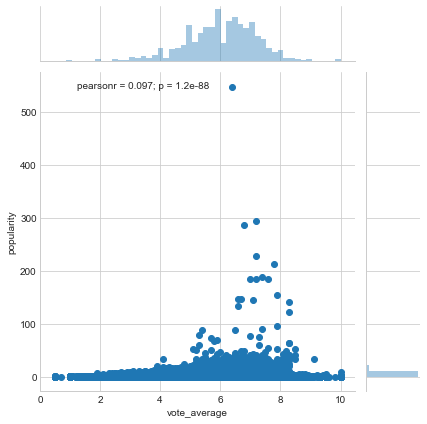

In [50]:
sns.jointplot(x='vote_average', y='popularity', data=df)

Surprisingly, the Pearson Coefficient of the two aforementioned quantities is a measly **0.097** which suggests that **there is no tangible correlation**. In other words, popularity and vote average and independent quantities. It would be interesting to discover how TMDB assigns numerical popularity scores to its movies.

### Movie Release Dates

Release Dates can often play a very important role in determining the success and the revenue generated by a particular movie. In this section, we will try and gain insights about release dates in terms of years, months and days of the week. 

We have already constructed the **year** feature in our preliminary data wrangling step. Let us now extract the month and day too for each movie with a release date.

In [51]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [52]:
def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

In [53]:
def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('-'))    
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan

In [54]:
df['day'] = df['release_date'].apply(get_day)
df['month'] = df['release_date'].apply(get_month)

With these features in hand, let us now check the most popular and most successful months and days.

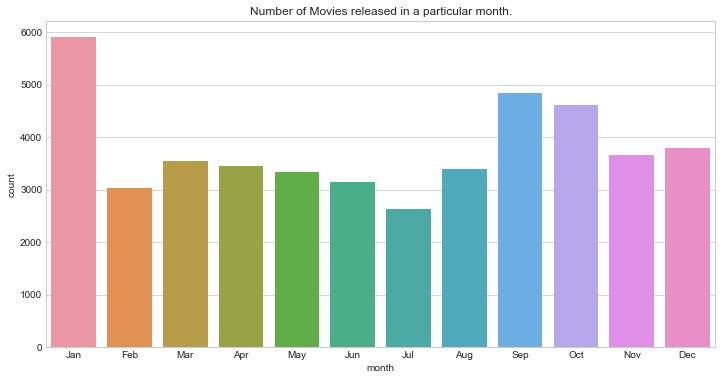

In [55]:
plt.figure(figsize=(12,6))
plt.title("Number of Movies released in a particular month.")
sns.countplot(x='month', data=df, order=month_order)

It appears that **January** is the most popular month when it comes to movie releases. In Hollywood circles, this is also known as the *the dump month* when sub par movies are released by the dozen. 

In which months do bockbuster movies tend to release? To answer this question, we will consider all movies that have made in excess of 100 million dollars and calculate the average gross for each month.

/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead



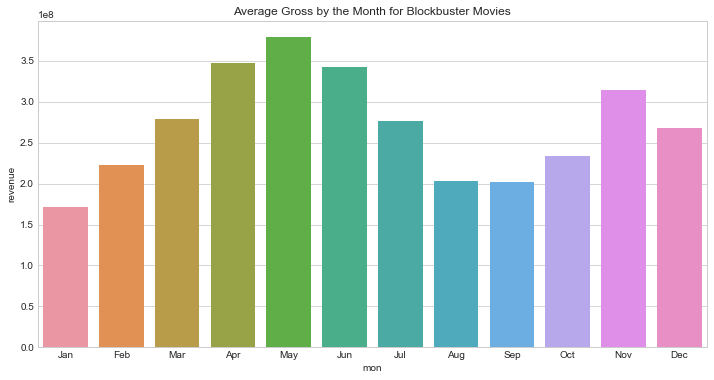

In [56]:
month_mean = pd.DataFrame(df[df['revenue'] > 1e8].groupby('month')['revenue'].mean())
month_mean['mon'] = month_mean.index
plt.figure(figsize=(12,6))
plt.title("Average Gross by the Month for Blockbuster Movies")
sns.barplot(x='mon', y='revenue', data=month_mean, order=month_order)

We see that the months of **April**, **May** and **June** have the highest average gross among high grossing movies. This can be attributed to the fact that blockbuster movies are usually released in the summer when the kids are out of school and the parents are on vacation and therefore, the audience is more likely to spend their disposable income on entertainment.

Do some months tend to be more successful than others? Let us visualise the boxplot between the return and the months.

/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead



(0, 12)

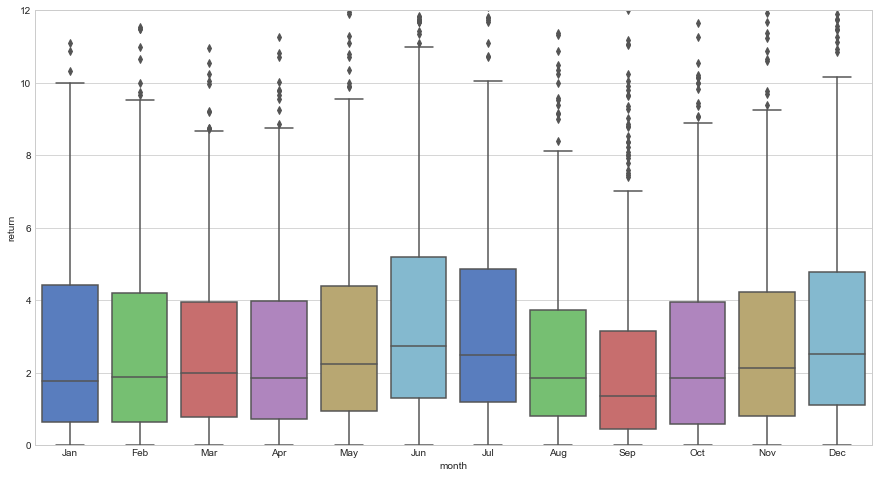

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='month', y='return', data=df[df['return'].notnull()], palette="muted", ax =ax, order=month_order)
ax.set_ylim([0, 12])

The months of **June** and **July** tend to yield the highest median returns. **September** is the least successful months on the aforementioned metrics. Again, the success of June and July movies can be attributed to them being summer months and times of vacation. September usually denotes the beginning of the school/college semester and hence a slight reduction in the consumption of movies.

Let us now have a look at the most popular days as we did for months.

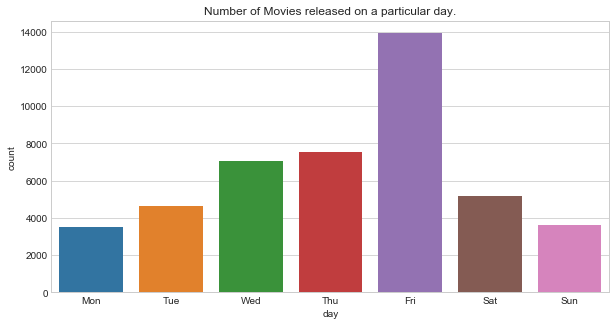

In [58]:
plt.figure(figsize=(10,5))
plt.title("Number of Movies released on a particular day.")
sns.countplot(x='day', data=df, order=day_order)

**Friday** is clearly the most popular day for movie releases. This is understandable considering the fact that it usually denotes the beginning of the weekend. **Sunday** and **Monday** are the least popular days and this can be attributed to the same aforementioned reason.

#### Number of Movies by the year

The Dataset of 45,000 movies available to us does not represent the entire corpus of movies released since the inception of cinema. However, it is reasomnable to assume that it does include almost every major film released in Hollywood as well as other major film industries across the world (such as Bollywood in India). With this assumption in mind, let us take a look at the number of movies produced by the year.

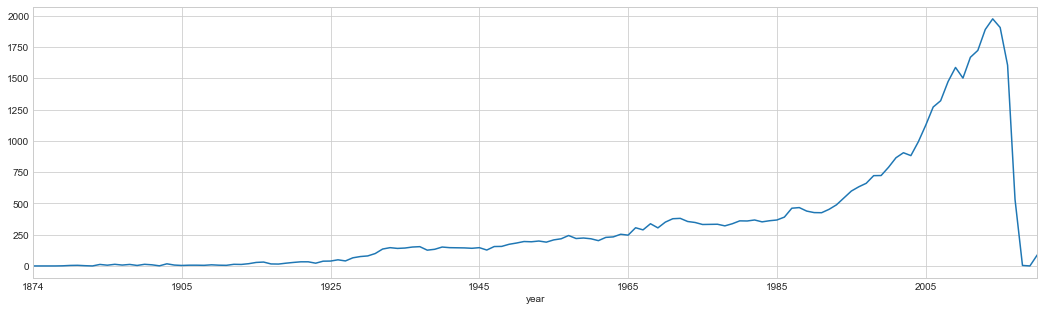

In [59]:
year_count = df.groupby('year')['title'].count()
plt.figure(figsize=(18,5))
year_count.plot()

We notice that there is a sharp rise in the number of movies **starting the 1990s decade.** However, we will not look too much into this as it is entirely possible that recent movies were oversampled for the purposes of this dataset.

Next, let us take a look at the earliest movies represented in the dataset.

#### Earliest Movies Represented

In [60]:
df[df['year'] != 'NaT'][['title', 'year']].sort_values('year').head(10)

,title,year
34940,Passage of Venus,1874
34937,Sallie Gardner at a Gallop,1878
41602,Buffalo Running,1883
34933,Man Walking Around a Corner,1887
34934,Accordion Player,1888
34938,Traffic Crossing Leeds Bridge,1888
34936,"Monkeyshines, No. 2",1890
34939,London's Trafalgar Square,1890
34935,"Monkeyshines, No. 1",1890
41194,Mosquinha,1890


The oldest movie, **Passage of Venus**, wss a series of photographs of the transit of the planet Venus across the Sun in 1874. They were taken in Japan by the French astronomer Pierre Janssen using his 'photographic revolver'. This is also the oldest movie on both IMDB and TMDB.

Finally, in this section, let us construct a heatmap to indicate movie releases by month and year for all movies released in this century. This will give us a good idea of the *hot* and *cold* months for movie buffs.

In [61]:
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

In [62]:
df_21 = df.copy()
df_21['year'] = df_21[df_21['year'] != 'NaT']['year'].astype(int)
df_21 = df_21[df_21['year'] >=2000]
hmap_21 = pd.pivot_table(data=df_21, index='month', columns='year', aggfunc='count', values='title')
hmap_21 = hmap_21.fillna(0)

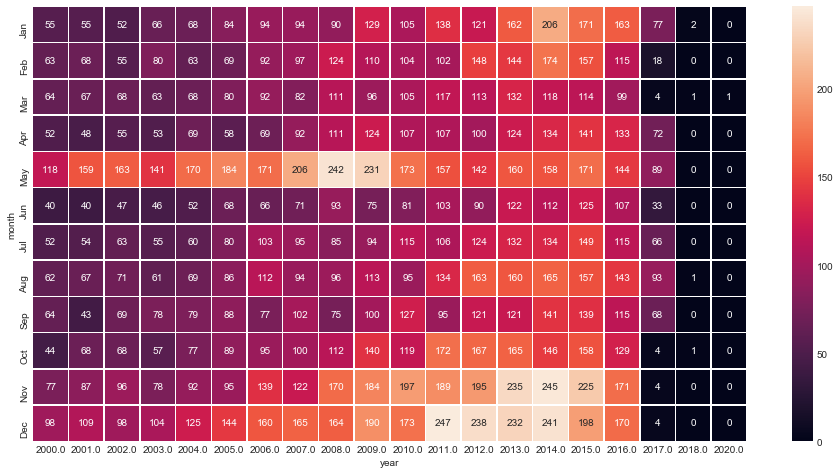

In [63]:
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(hmap_21, annot=True, linewidths=.5, ax=ax, fmt='n', yticklabels=month_order)

### Movie Status

Although not entirely relevant to our analysis of movies, gathering information on the various kinds of movies based on their status of release can provide us interesitng insight on the nature of the movies present in our dataset. My preliminary hunch was that almost every movie has the **Released** status. Let's find out.

In [64]:
df['status'].value_counts()

Released           45014
Rumored              230
Post Production       98
In Production         20
Planned               15
Canceled               2
Name: status, dtype: int64

Almost every movie is indeed released. However, it is interesting to see that MovieLens has user ratings for movies that are still in the planning, production and post production stage. We might take this information into account while building our collaborative filtering recommendation engine.

### Spoken Languages

Does the number of spoken languages influence the success of a movie? To do this, we will convert our **spoken_languages** feature to a numeric feature denoting the number of languages spoken in that film.

In [65]:
df['spoken_languages'] = df['spoken_languages'].fillna('[]').apply(ast.literal_eval).apply(lambda x: len(x) if isinstance(x, list) else np.nan)

In [66]:
df['spoken_languages'].value_counts()

1     33736
2      5371
0      3835
3      1705
4       550
5       178
6        62
7        14
8         6
9         5
19        1
13        1
12        1
10        1
Name: spoken_languages, dtype: int64

Most movies have just one language spoken in the entire duration of the film. **19** is the higest number of languages spoken in a film. Let us take a look at all the films with more than 10 spoken languages.

In [67]:
df[df['spoken_languages'] >= 10][['title', 'year', 'spoken_languages']].sort_values('spoken_languages', ascending=False)

,title,year,spoken_languages
22235,Visions of Europe,2004,19
35288,The Testaments,2000,13
14093,To Each His Own Cinema,2007,12
8789,The Adventures of Picasso,1978,10


The movie with the most number of languages, **Visions of Europe** is actually a collection of 25 short films by 25 different European directors. This explains the sheer diversity of the movie in terms of language.

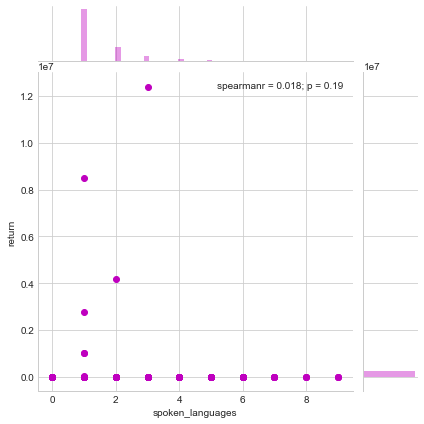

In [68]:
sns.jointplot(x="spoken_languages", y="return", data=df, stat_func=stats.spearmanr, color="m")

The **Spearman Coefficient** is 0.018 indicating no correlation between the two quantities.

### Runtime

From its humble beginnings of 1 minute slient, black \& white clips to epic 3 hour visual delights, movies have a come a long way in terms of runtime. In this section, let us try and gain some additional insights about the nature of movie lengths and their evolution over time.

In [69]:
df['runtime'].describe()

count    45203.000000
mean        94.128199
std         38.407810
min          0.000000
25%         85.000000
50%         95.000000
75%        107.000000
max       1256.000000
Name: runtime, dtype: float64

The average length of a movie is about 1 hour and 30 minutes. The longest movie on record in this dataset is a **staggering 1256 minutes (or 20 hours) long.**

In [70]:
df['runtime'] = df['runtime'].astype('float')

We are aware that most movies are less than 5 hours (or 300 minutes) long. Let us plot a distribution of these mainstream movies.

/usr/local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning:

object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.



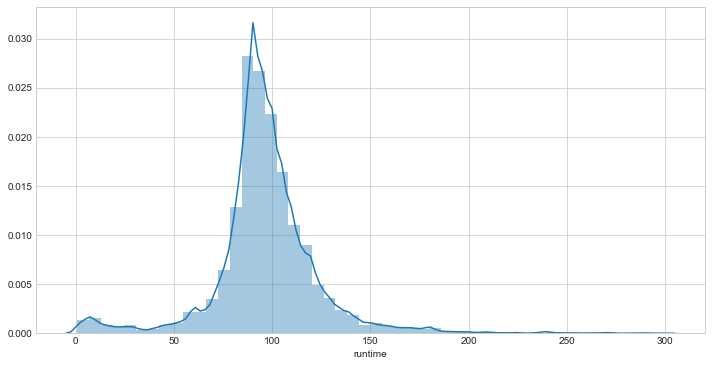

In [71]:
plt.figure(figsize=(12,6))
sns.distplot(df[(df['runtime'] < 300) & (df['runtime'] > 0)]['runtime'])

Is there any meaningful relationship between runtime and return? Let us find out!

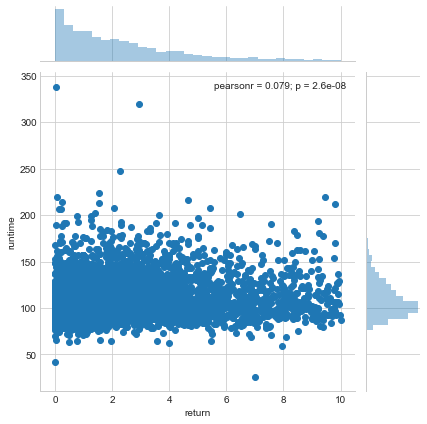

In [72]:
df_mat = df[(df['return'].notnull()) & (df['runtime'] > 0) & (df['return'] < 10)]
sns.jointplot('return', 'runtime', data=df_mat)
plt.show()

There seems to be relationship between the two quantities. **The duration of a movie is independent of its success.** However, I have a feeling this might not be the case with duration and budget. A longer movie should entail a higher budget. Let us find out if this is really the case.

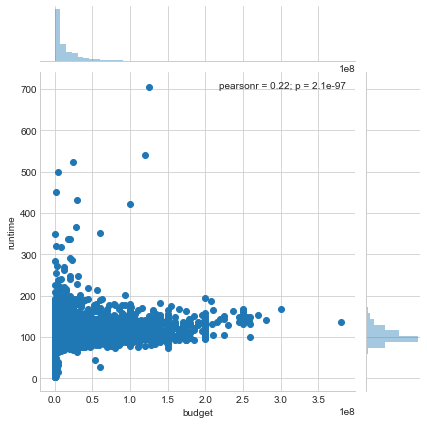

In [73]:
df_mat = df[(df['budget'].notnull()) & (df['runtime'] > 0)]
sns.jointplot('budget', 'runtime', data=df_mat)
plt.show()

The two quantities have a much weaker correlation than I had expected. In retrospect, the genre of the movie tends to have a much greater impact on budget. A 3 hour art film will cost significantly lesser than a 90 minute Sci-Fi movie. 

Next, I'd like to see the average lengths of movies through time, right from the 1890s to the 2017s. It would be interesting to see the trends in what filmmakers adjudged would be the appropriate length of a movie at that time.

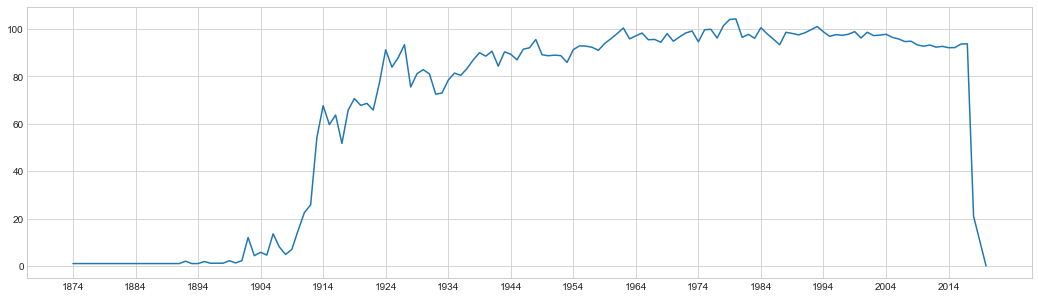

In [74]:
plt.figure(figsize=(18,5))
year_runtime = df[df['year'] != 'NaT'].groupby('year')['runtime'].mean()
plt.plot(year_runtime.index, year_runtime)
plt.xticks(np.arange(1874, 2024, 10.0))
plt.show()

We notice that films started hitting the **60 minute mark as early as 1914**. Starting **1924**, films started having the traiditonal 90 minute duration and has remained more or less constant ever since.

Finally in this section, let us see the longest and the shortest movies of all time (with respect to the movies in the dataset). 

#### Shortest Movies

In [75]:
df[df['runtime'] > 0][['runtime', 'title', 'year']].sort_values('runtime').head(10)

,runtime,title,year
35146,1.0,La Vague,1891
36577,1.0,Champs de Mars,1900
36576,1.0,Palace of Electricity,1900
44965,1.0,"Luis Martinetti, Contortionist",1894
42357,1.0,A Gathering of Cats,2007
36575,1.0,Eiffel Tower from Trocadero Palace,1900
36574,1.0,Panorama of Eiffel Tower,1900
44714,1.0,The Infernal Caldron,1903
19244,1.0,The Kiss,1896
44646,1.0,The Vanishing Lady,1896


We see that every movie in this list except **A Gathering of Cats** were filmed in the late 1890s and the beginning of the 20th century. All these movies were one minute long.

#### Longest Movies

In [76]:
df[df['runtime'] > 0][['runtime', 'title', 'year']].sort_values('runtime', ascending=False).head(10)

,runtime,title,year
24178,1256.0,Centennial,1978
40938,1140.0,Baseball,1994
19965,1140.0,Jazz,2001
13767,931.0,Berlin Alexanderplatz,1980
13953,925.0,Heimat: A Chronicle of Germany,1984
27855,900.0,The Story of Film: An Odyssey,2011
26682,877.0,Taken,2002
19158,874.0,The War,2007
34667,840.0,The Roosevelts: An Intimate History,2014
34732,840.0,Seventeen Moments in Spring,1973


We notice that almost all the entries in the above chart are actually miniseries and hence, do not count as feature length films. We cannot gather too much insight from this list of longest movies as there is no way of distinguishing feature length films from TV Mini Series from our dataset (except, of course, by doing it manually).

### Budget

Let us now turn our attention to budget. We expect budgets to be a skewed quantity and also heavily influenced by inflation. Nevertheless, it would be interesting to gather as much insights as possible from this quantity as budget is often a critical feature in predicting movie revenue and success. As a start, let us gather the summary statistics for our budget.

In [77]:
df['budget'].describe()

count    8.890000e+03
mean     2.160428e+07
std      3.431063e+07
min      1.000000e+00
25%      2.000000e+06
50%      8.000000e+06
75%      2.500000e+07
max      3.800000e+08
Name: budget, dtype: float64

The mean budget of a film is 21.6 million dollars whereas the median budget is far smaller at 8 million dollars. This strongly suggests the mean being influenced by outliers. 

/usr/local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning:

object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.



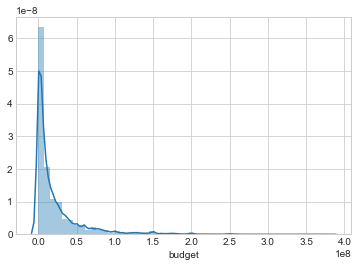

In [78]:
sns.distplot(df[df['budget'].notnull()]['budget'])

The distribution of movie budgets shows an exponential decay. More than 75% of the movies have a budget smaller than 25 million dollars. Next, let us take a look at the most expensive movies of all time and the revenue & returns that they generated.

#### Most Expensive Movies of all Time

In [79]:
df[df['budget'].notnull()][['title', 'budget', 'revenue', 'return', 'year']].sort_values('budget', ascending=False).head(10)

,title,budget,revenue,return,year
17124,Pirates of the Caribbean: On Stranger Tides,380000000.0,1.045714e+09,2.751878,2011
11827,Pirates of the Caribbean: At World's End,300000000.0,9.610000e+08,3.203333,2007
26558,Avengers: Age of Ultron,280000000.0,1.405404e+09,5.019299,2015
11067,Superman Returns,270000000.0,3.910812e+08,1.448449,2006
44842,Transformers: The Last Knight,260000000.0,6.049421e+08,2.326701,2017
16130,Tangled,260000000.0,5.917949e+08,2.276134,2010
18685,John Carter,260000000.0,2.841391e+08,1.092843,2012
11780,Spider-Man 3,258000000.0,8.908716e+08,3.452991,2007
21175,The Lone Ranger,255000000.0,8.928991e+07,0.350157,2013
22059,The Hobbit: The Desolation of Smaug,250000000.0,9.584000e+08,3.833600,2013


Two **Pirates of the Carribean** films occupy the top spots in this list with a staggering budget of over **300 million dollars**. All the top 10 most expensive films made a profit on their investment except for **The Lone Ranger** which managed to recoup less than 35% of its investment, taking in a paltry 90 million dollars on a **255 million dollar** budget.

How strong a correlation does the budget hold with the revenue? A stronger correlation would directly imply more accurate forecasts.

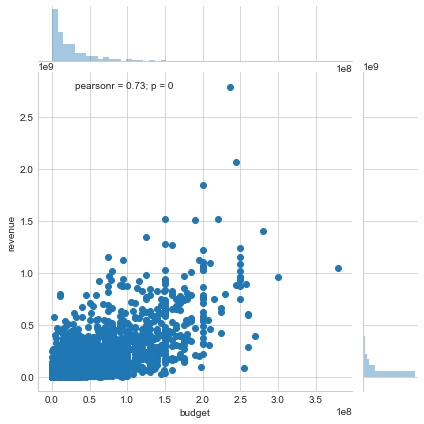

In [80]:
sns.jointplot(x='budget',y='revenue',data=df[df['return'].notnull()])

The pearson r value of **0.73** between the two quantities indicates a very strong correlation. 

### Revenue

The final numeric feature we will explore is the revenue. The revenue is probably the most important numeric quantity associated with a movie. We will try to predict the revenue for movies given a set of features in a later section. The treatment of revenue will be very similar to that of budget and we will once again begin by studying the summary statistics.

In [81]:
df['revenue'].describe()

count    7.408000e+03
mean     6.878739e+07
std      1.464203e+08
min      1.000000e+00
25%      2.400000e+06
50%      1.682272e+07
75%      6.722707e+07
max      2.787965e+09
Name: revenue, dtype: float64

The mean gross of a movie is **68.7 million dollars** whereas the median gross is much lower at **16.8 million dollars**, suggesting the skewed nature of revenue. The lowest revenue generated by a movie is **just 1 dollar** whereas the highest grossing movie of all time has raked in an astonishing **2.78 billion dollars.*

/usr/local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning:

object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.



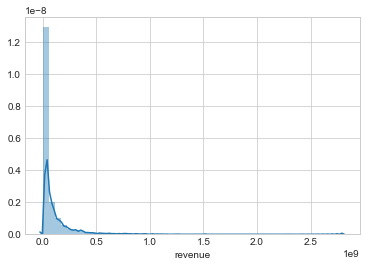

In [82]:
sns.distplot(df[df['revenue'].notnull()]['revenue'])

The distribution of revenue undergoes exponential decay just like budget. We also found that the two quantities were strongly correlated. Let us now take a look at the highest and least grossing movies of all time.

#### Highest Grossing Films of All Time

In [83]:
gross_top = df[['poster_path', 'title', 'budget', 'revenue', 'year']].sort_values('revenue', ascending=False).head(10)
pd.set_option('display.max_colwidth', 100)
HTML(gross_top.to_html(escape=False))

,poster_path,title,budget,revenue,year
14551,,Avatar,237000000.0,2.787965e+09,2009
26555,,Star Wars: The Force Awakens,245000000.0,2.068224e+09,2015
1639,,Titanic,200000000.0,1.845034e+09,1997
17818,,The Avengers,220000000.0,1.519558e+09,2012
25084,,Jurassic World,150000000.0,1.513529e+09,2015
28830,,Furious 7,190000000.0,1.506249e+09,2015
26558,,Avengers: Age of Ultron,280000000.0,1.405404e+09,2015
17437,,Harry Potter and the Deathly Hallows: Part 2,125000000.0,1.342000e+09,2011
22110,,Frozen,150000000.0,1.274219e+09,2013
42222,,Beauty and the Beast,160000000.0,1.262886e+09,2017


In [84]:
pd.set_option('display.max_colwidth', 50)

These figures have not been adjusted for inflation. Therefore, we see a disproportionate number of movies from very recent times in the top 10 list. To get an understanding of the revenue garnered by movies, let us plot the maximum revenue through the years.

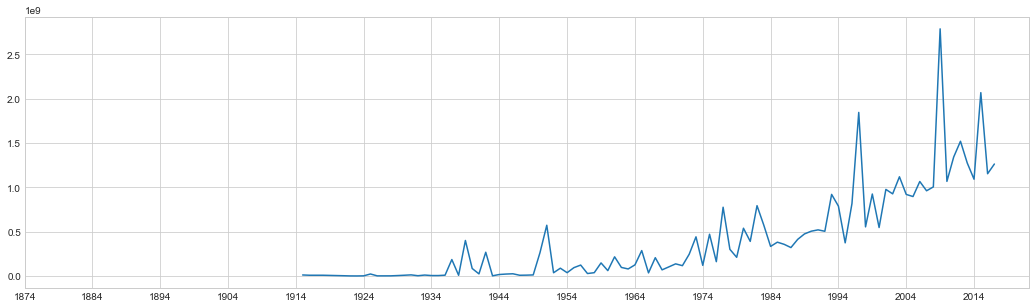

In [85]:
plt.figure(figsize=(18,5))
year_revenue = df[(df['revenue'].notnull()) & (df['year'] != 'NaT')].groupby('year')['revenue'].max()
plt.plot(year_revenue.index, year_revenue)
plt.xticks(np.arange(1874, 2024, 10.0))
plt.show()

As can be seen from the figure, the maximum gross has steadily risen over the years. The world of movies broke the 1 billion dollar mark in 1997 with the release of **Titanic**. It took another 12 years to break the 2 billion dollar mark with **Avatar**. Both these movies were directed by James Cameron.

### Returns

We will not look too much into returns for the time being. Let us just check the least and the most successful movies of all time. To do this, we will only consider those movies which have a budget greater than 5 million dollars.

#### Most Successful Movies

In [86]:
df[(df['return'].notnull()) & (df['budget'] > 5e6)][['title', 'budget', 'revenue', 'return', 'year']].sort_values('return', ascending=False).head(10)

,title,budget,revenue,return,year
1065,E.T. the Extra-Terrestrial,10500000.0,792965326.0,75.520507,1982
256,Star Wars,11000000.0,775398007.0,70.490728,1977
1338,Jaws,7000000.0,470654000.0,67.236286,1975
1888,The Exorcist,8000000.0,441306145.0,55.163268,1973
352,Four Weddings and a Funeral,6000000.0,254700832.0,42.450139,1994
834,The Godfather,6000000.0,245066411.0,40.844402,1972
4492,Look Who's Talking,7500000.0,296000000.0,39.466667,1989
24258,Annabelle,6500000.0,255273813.0,39.272894,2014
1056,Dirty Dancing,6000000.0,213954274.0,35.659046,1987
1006,The Sound of Music,8200000.0,286214286.0,34.904181,1965


#### Worst Box Office Disasters

In [87]:
df[(df['return'].notnull()) & (df['budget'] > 5e6) & (df['revenue'] > 10000)][['title', 'budget', 'revenue', 'return', 'year']].sort_values('return').head(10)

,title,budget,revenue,return,year
11159,Chaos,20000000.0,10289.0,0.000514,2005
19027,5 Days of War,20000000.0,17479.0,0.000874,2011
21034,Special Forces,10000000.0,10759.0,0.001076,2011
25732,Foodfight!,65000000.0,73706.0,0.001134,2012
38388,Term Life,16500000.0,21256.0,0.001288,2016
19505,Laurence Anyways,9500000.0,12250.0,0.001289,2012
12038,The Good Night,15000000.0,20380.0,0.001359,2007
3966,Cherry 2000,10000000.0,14000.0,0.001400,1987
22097,Twice Born,13000000.0,18295.0,0.001407,2012
5651,All The Queen's Men,15000000.0,23000.0,0.001533,2001


With these analyses in place, we are in a good position to construct our correlation matrix.

In [88]:
df['year'] = df['year'].replace('NaT', np.nan)

In [89]:
df['year'] = df['year'].apply(clean_numeric)

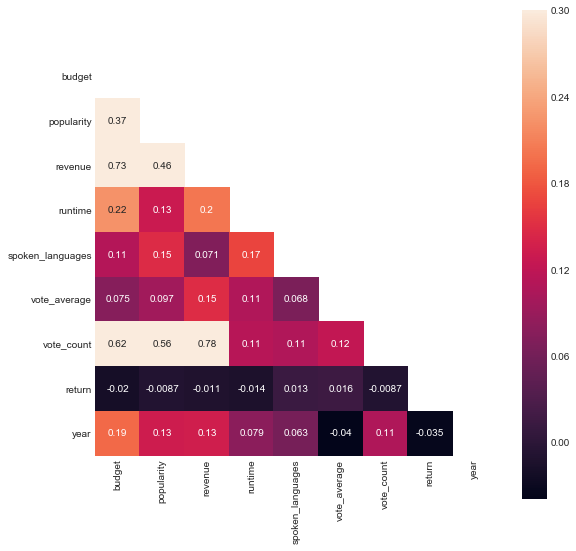

In [90]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(9,9))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

### Genres

In [91]:
df['genres'] = df['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [92]:
s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

In [93]:
gen_df = df.drop('genres', axis=1).join(s)

In [94]:
gen_df['genre'].value_counts().shape[0]

32

TMDB defines 32 different genres for our set of 45,000 movies. Let us now have a look at the most commonly occuring genres in movies.

In [95]:
pop_gen = pd.DataFrame(gen_df['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'movies']
pop_gen.head(10)

,genre,movies
0,Drama,20265
1,Comedy,13182
2,Thriller,7624
3,Romance,6735
4,Action,6596
5,Horror,4673
6,Crime,4307
7,Documentary,3932
8,Adventure,3496
9,Science Fiction,3049


/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead



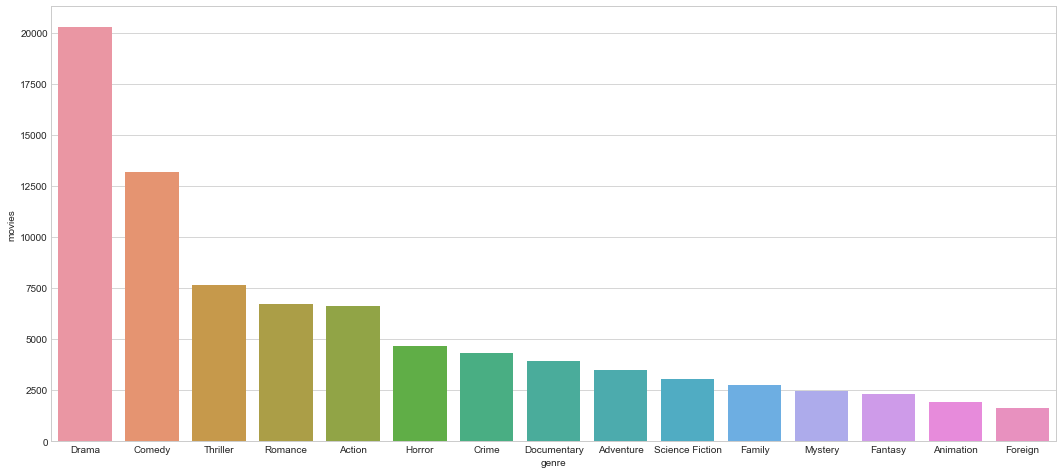

In [96]:
plt.figure(figsize=(18,8))
sns.barplot(x='genre', y='movies', data=pop_gen.head(15))
plt.show()

**Drama** is the most commonly occuring genre with almost half the movies identifying itself as a drama film. **Comedy** comes in at a distant second with 25% of the movies having adequate doses of humor. Other major genres represented in the top 10 are Action, Horror, Crime, Mystery, Science Fiction, Animation and Fantasy.

The next question I want to answer is the trends in the share of genres of movies across the world. Has the demand for Science Fiction movies increased? Do certain years have a disproportionate share of Animation Movies? Let's find out!

We will only be looking at trends starting 2000. We will consider only those themes that appear in the top 15 most popular genres. We will exclude Documentaries, Family and Foreign Movies from our analysis.

In [97]:
genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Adventure', 'Science Fiction', 'Mystery', 'Fantasy', 'Mystery', 'Animation']

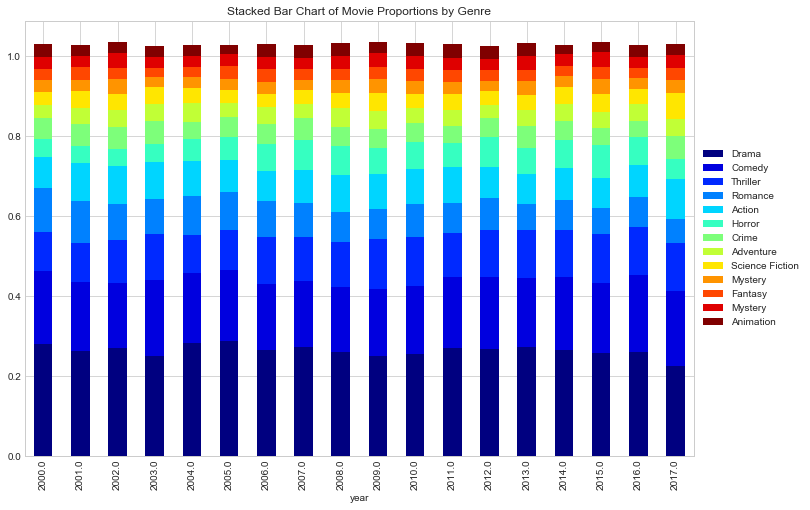

In [98]:
pop_gen_movies = gen_df[(gen_df['genre'].isin(genres)) & (gen_df['year'] >= 2000) & (gen_df['year'] <= 2017)]
ctab = pd.crosstab([pop_gen_movies['year']], pop_gen_movies['genre']).apply(lambda x: x/x.sum(), axis=1)
ctab[genres].plot(kind='bar', stacked=True, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Stacked Bar Chart of Movie Proportions by Genre")
plt.show()

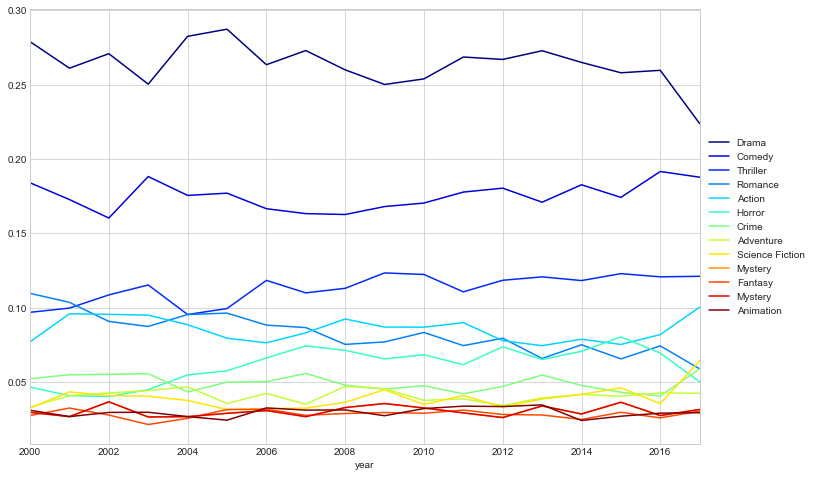

In [99]:
ctab[genres].plot(kind='line', stacked=False, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The proportion of movies of each genre has remained fairly constant since the beginning of this century except for **Drama**. The proportion of drama films has fallen by over 5%.  **Thriller** movies have enjoyed a slight increase in their share. 

One question that I have always had is that if some genres are particularly more successful than others. For example, we should expect Science Fiction and Fantasy Movies to bring in more revenue than other genres but when normalized with their budget, do they prove to be as successful? We will visualize two violin plots to answer this question. One will be genres versus the revenue while the other will be versus returns.

In [100]:
violin_genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Science Fiction', 'Fantasy', 'Animation']
violin_movies = gen_df[(gen_df['genre'].isin(violin_genres))]

/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead



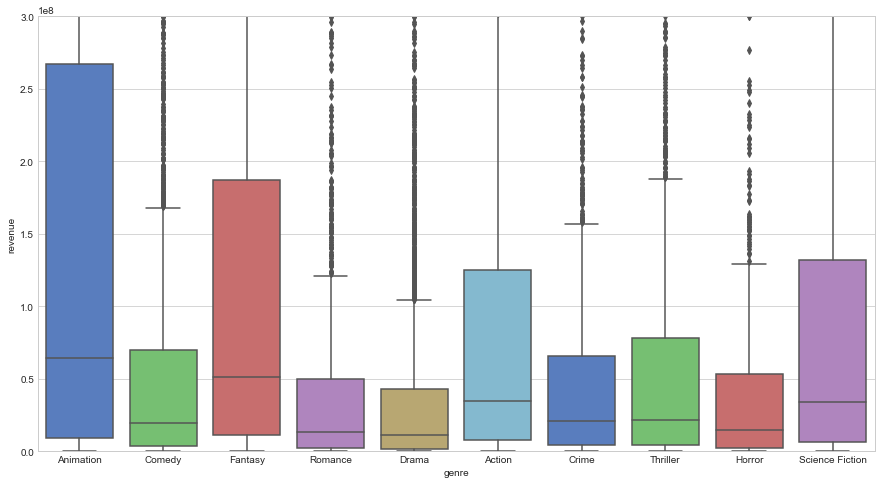

In [101]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='genre', y='revenue', data=violin_movies, palette="muted", ax =ax)
ax.set_ylim([0, 3e8])
plt.show()

**Animation** movies has the largest 25-75 range as well as the median revenue among all the genres plotted. **Fantasy** and **Science Fiction** have the second and third highest median revenue respectively. 

/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead



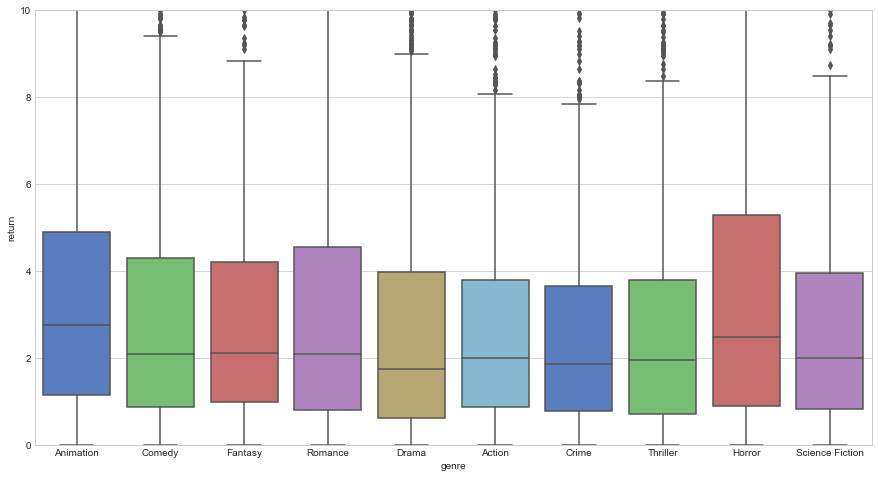

In [102]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='genre', y='return', data=violin_movies, palette="muted", ax =ax)
ax.set_ylim([0, 10])
plt.show()

From the boxplot, it seems like **Animation** Movies tend to yield the highest returns on average. **Horror** Movies also tend to be a good bet. This is partially due to the nature of Horror movies being low budget compared to Fantasy Movies but being capable of generating very high revenues relative to its budget.

### Cast and Crew

Let us now take a look at the cast and crew of our movies. We do not have these details with us in our main dataset. However, we have a separate file consisting of the full cast and crew credits of all the Movielens Movies. Let us take a look at this credits data.

In [103]:
credits_df = pd.read_csv('data/credits.csv')
credits_df.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


#### Credits Dataset

* **cast:** A stringified list of dictionaries consisting of cast names and the corresponding characters they played.
* **crew:** A stringified list of dictionaries consisting of crew names and the function they performed.
* **id:** The TMDB ID of movie.

We need to perform a left join of our original movies metadata dataframe with the credits dataframe on the TMDB Movie ID. Before we are able to perform this join, we need to make sure that the ID column of our main dataframe is clean and of type integer. To do this, let us try to perform an integer conversion of our IDs and if an exception is raised,we will replace the ID with NaN. We will then proceed to drop these rows from our dataframe.

In [104]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [105]:
df['id'] = df['id'].apply(convert_int)

In [106]:
df[df['id'].isnull()]

,belongs_to_collection,budget,genres,homepage,id,original_language,overview,popularity,poster_path,production_companies,...,status,tagline,title,video,vote_average,vote_count,return,year,day,month
19730,0.065736,NaN,"[Carousel Productions, Vision View Entertainme...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",NaN,104.0,Released,NaN,<img src='http://image.tmdb.org/t/p/w185/Midni...,[],...,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,1.931659,NaN,"[Aniplex, GoHands, BROSTA TV, Mardock Scramble...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,68.0,Released,NaN,<img src='http://image.tmdb.org/t/p/w185/Mardo...,[],...,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,2.185485,NaN,"[Odyssey Media, Pulser Productions, Rogue Stat...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",NaN,82.0,Released,NaN,<img src='http://image.tmdb.org/t/p/w185/Avala...,[],...,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
df = df.drop([19730, 29503, 35587])

In [108]:
df['id'] = df['id'].astype('int')

In [109]:
df = df.merge(credits_df, on='id')
df.shape

(45538, 27)

In [110]:
df['cast'] = df['cast'].apply(ast.literal_eval)
df['crew'] = df['crew'].apply(ast.literal_eval)

In [111]:
df['cast_size'] = df['cast'].apply(lambda x: len(x))
df['crew_size'] = df['crew'].apply(lambda x: len(x))

In [112]:
df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [113]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [114]:
df['director'] = df['crew'].apply(get_director)

In [115]:
s = df.apply(lambda x: pd.Series(x['cast']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'actor'
cast_df = df.drop('cast', axis=1).join(s)

Let us now take a look at the actors and the directors who have raked in the most amount of money with their movies.

#### Actors with the Highest Total Revenue

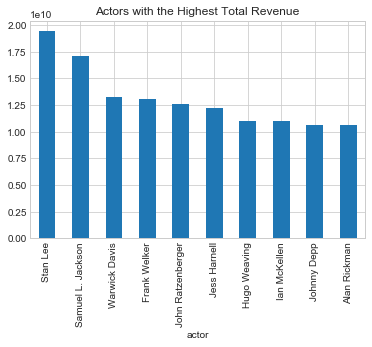

In [116]:
plt.title('Actors with the Highest Total Revenue')
cast_df.groupby('actor')['revenue'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.show()

#### Directors with the Highest Total Revenue

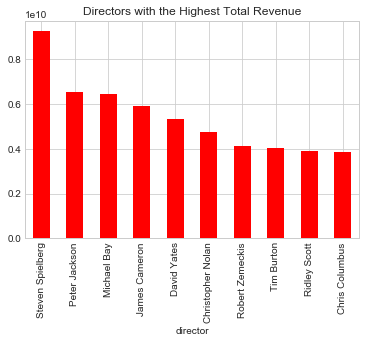

In [117]:
plt.title('Directors with the Highest Total Revenue')
df.groupby('director')['revenue'].sum().sort_values(ascending=False).head(10).plot(kind='bar', colormap='autumn')
plt.show()

For average revenues, we will consider only actors and directors who have acted and directed in at least 5 movies respectively.

In [118]:
actor_list = cast_df.groupby('actor')['revenue'].count().sort_values(ascending=False)
actor_list = list(actor_list[actor_list >= 5].index)
director_list = df.groupby('director')['revenue'].count().sort_values(ascending=False)
director_list = list(director_list[director_list >= 5].index)

#### Actors with Highest Average Revenue

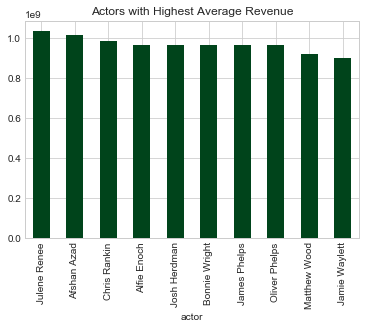

In [119]:
plt.title("Actors with Highest Average Revenue")
cast_df[cast_df['actor'].isin(actor_list)].groupby('actor')['revenue'].mean().sort_values(ascending=False).head(10).plot(kind='bar', colormap='Greens_r')
plt.show()

#### Directors with Highest Average Revenue

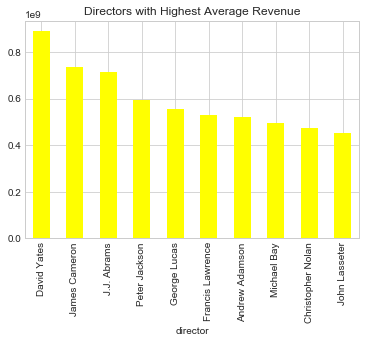

In [120]:
plt.title("Directors with Highest Average Revenue")
df[df['director'].isin(director_list)].groupby('director')['revenue'].mean().sort_values(ascending=False).head(10).plot(kind='bar', colormap='autumn_r')
plt.show()

Which actors and directors are the safest bet? For this, we will consider the average return brought in by a particular director or actor. We will only consider those movies that have raked in at least 10 million dollars. Also, we will only consider actors and directors that have worked in at least 5 films.

#### Most Successful Actors

In [121]:
success_df = cast_df[(cast_df['return'].notnull()) & (cast_df['revenue'] > 1e7) & (cast_df['actor'].isin(actor_list))]
pd.DataFrame(success_df.groupby('actor')['return'].mean().sort_values(ascending=False).head(10))

,return
actor,
Jami Gertz,3.099099e+06
Donna Mitchell,2.479289e+06
Andrew McCarthy,2.479280e+06
Nicholas Pryor,1.770914e+06
James Spader,1.549551e+06
Michael Bowen,1.033038e+06
Robert Downey Jr.,5.165189e+05
Martin Kove,3.395458e+05
William Zabka,3.395441e+05


#### Most Successful Directors

In [122]:
success_df = df[(df['return'].notnull()) & (df['revenue'] > 1e7) & (df['director'].isin(director_list))]
pd.DataFrame(success_df.groupby('director')['return'].mean().sort_values(ascending=False).head(10))

,return
director,
John G. Avildsen,169822.750468
George A. Romero,60.656935
George Lucas,54.328446
Martha Coolidge,49.553131
Davis Guggenheim,46.243000
George Miller,39.076975
James Wan,27.659835
Guy Hamilton,25.779057
John Badham,25.433532


**John G. Avildsen** has an unnaturally high return. All the other directors in the list are nowhere close to the level of return that he has gained. Let us have a look at his movies.

In [123]:
df[(df['director'] == 'John G. Avildsen') & (df['return'].notnull())][['title', 'budget', 'revenue', 'return', 'year']]

,title,budget,revenue,return,year
1853,Rocky,1000000.0,117235147.0,1.172351e+02,1976.0
2307,Rocky V,42000000.0,119946358.0,2.855866e+00,1990.0
2315,The Karate Kid,8000000.0,90815558.0,1.135194e+01,1984.0
2316,"The Karate Kid, Part II",113.0,115103979.0,1.018619e+06,1986.0
5226,Joe,106000.0,19319254.0,1.822571e+02,1970.0
5658,Neighbors,8500000.0,29916207.0,3.519554e+00,1981.0


**The Karate Kid, Part II** has a budget of only 113 dollars. This seems like an anomaly since official figures state that the movie cost **13 million dollars**. So, although he has directed amazing movies, he does not belong to this list.

We will end our Exploratory Data Analysis over here. Let us use some of the insights we gained in this section and build some useful predictive models.

## Regression: Predicting Movie Revenues

In this section, I will attempt at building a regression model to predict movie revenues. Since this isn't one of the main goals of this project, I will not spend too much time feature engineering or hyperparamater tuning my model. 

Predicting Movie Revenues is an extremely popular problem in Machine Learning which has created a huge amount of literature. Most of the models proposed in these papers use far more potent features than what we possess at the moment. These include Facebook Page Likes, Information on Tweets about the Movie, YouTube Trailer Reaction (Views, Likes, Dislikes, etc.), Movie Rating (MPCAA, CBIFC) among many others.

To compensate for the lack of these features, we are going to cheat a little. We will be using TMDB's **Popularity Score** and **Vote Average** as our features in our model to assign a nuerical value to popularity. However, it must be kept in mind that these metrics will not be available when predicting movie revenues in the real world, when the movie has not been released yet.

In [124]:
rgf = df[df['return'].notnull()]
rgf.shape

(5393, 30)

We have **5393 records** in our training set. Let us take a look at the features we possess and remove the ones which are unnecessary.

In [125]:
rgf.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'return', 'year', 'day', 'month',
       'cast', 'crew', 'cast_size', 'crew_size', 'director'],
      dtype='object')

In [126]:
rgf = rgf.drop(['id', 'overview', 'poster_path', 'release_date', 'status', 'tagline', 'video', 'return', 'crew'], axis=1)

We will perform the following feature engineering tasks:

1. **belongs_to_collection** will be turned into a Boolean variable. 1 indicates a movie is a part of collection whereas 0 indicates it is not.
2. **genres** will be converted into number of genres.
3. **homepage** will be converted into a Boolean variable that will indicate if a movie has a homepage or not.
4. **original_language** will be replaced by a feature called **is_foreign** to denote if a particular film is in English or a Foreign Language.
5. **production_companies** will be replaced with just the number of production companies collaborating to make the movie.
6. **production_countries** will be replaced with the number of countries the film was shot in.
7. **day** will be converted into a binary feature to indicate if the film was released on a Friday.
8. **month** will be converted into a variable that indicates if the month was a holiday season.

In [127]:
def feature_engineering(df):
    df['belongs_to_collection'] = df['belongs_to_collection'].fillna('').apply(lambda x: 0 if x == '' else 1)
    df['genres'] = df['genres'].apply(lambda x: len(x))
    df['homepage'] = df['homepage'].apply(lambda x: 0 if x == np.nan else 1)
    df['is_english'] = df['original_language'].apply(lambda x: 1 if x=='en' else 0)
    df = df.drop('original_language', axis=1)
    df['production_companies'] = df['production_companies'].apply(lambda x: len(x))
    df['production_countries'] = df['production_countries'].apply(lambda x: len(x))
    df['is_Friday'] = df['day'].apply(lambda x: 1 if x=='Fri' else 0)
    df = df.drop('day', axis=1)
    df['is_Holiday'] = df['month'].apply(lambda x: 1 if x in ['Apr', 'May', 'Jun', 'Nov'] else 0)
    df = df.drop('month', axis=1)
    df = df.drop(['title', 'cast', 'director'], axis=1)
    df = pd.get_dummies(df, prefix='is')
    df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    df['vote_average'] = df['vote_average'].fillna(df['vote_average'].mean())
    return df

In [128]:
X, y = rgf.drop('revenue', axis=1), rgf['revenue']

In [129]:
X = feature_engineering(X)

In [130]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)

In [ ]:
X.shape

(5393, 17)

In [ ]:
reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

We get a Coefficient of Determination of **0.78** which is a pretty score for the basic model that we have built. Let us compare our model's score to a Dummy Regressor.

In [ ]:
dummy = DummyRegressor()
dummy.fit(train_X, train_y)
dummy.score(test_X, test_y)

We see that our model performs far more superiorly than the Dummy Regressor. Finally, let us plot the feature importances in the form of a bar plot to deduce which features were the most significant in our making predictions.

In [ ]:
plt.figure(figsize=(12,7))
sns.barplot(x=reg.feature_importances_, y=X.columns)

We notice that **vote_count**, a feature we *cheated* with, is the most important feature to our Gradient Boosting Model. This goes on to show the improtance of popularity metrics in determining the revenue of a movie. **Budget** was the second most important feature followed by **Popularity** (Literally, a popularity metric) and **Crew Size**.

## Classification: Predicting Movie Sucess

What factors influence whether a movie will be able to recoup its investments? I will try to answer this question by building a binary classifier that predicts if a movie will make a profit or a loss. As with our regression model, we will cheat a little and use features that may not be available to us in the real world for the lack of other useful popularity metrics.

We have already performed extensive analysis of our data and haven't done a lot with respect to determining factors that make a movie a success. We shall attempt at doing that in this section and follow it up by building our model.

In [ ]:
cls = df[df['return'].notnull()]
cls.shape

In [ ]:
cls.columns

In [ ]:
cls = cls.drop(['id', 'overview', 'poster_path', 'release_date', 'status', 'tagline', 'revenue'], axis=1)

Let us convert our **return** feature into a binary variable that will serve as our classes: **0** indicating a flop and **1** indicating a hit.

In [ ]:
cls['return'] = cls['return'].apply(lambda x: 1 if x >=1 else 0)

In [ ]:
cls['return'].value_counts()

Our classes seem to be fairly balanced. We do not need to apply any additional methods to deal with the imbalance of classes. Let us now turn our attention to our features.

In [ ]:
cls['belongs_to_collection'] = cls['belongs_to_collection'].fillna('').apply(lambda x: 0 if x == '' else 1)

In [ ]:
sns.set(style="whitegrid")
g = sns.PairGrid(data=cls, x_vars=['belongs_to_collection'], y_vars='return', size=5)
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))

It seems that movies that belong to a franchise have a higher probability of being a success. 

In [ ]:
cls['homepage'] = cls['homepage'].fillna('').apply(lambda x: 0 if x == '' else 1)
g = sns.PairGrid(data=cls, x_vars=['homepage'], y_vars='return', size=5)
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))

We see that with homepages, there is not a very huge difference in probability. To avoid the curse of dimensionality, we will eliminate this feature as it is not very useful.

In [ ]:
s = cls.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_cls = cls.drop('genres', axis=1).join(s)

In [ ]:
ctab = pd.crosstab([gen_cls['genre']], gen_cls['return'], dropna=False).apply(lambda x: x/x.sum(), axis=1)
ctab.plot(kind='bar', stacked=True, legend=False)

We find that **TV Movies** have a 0% Failure Rate but that is most probably because they are extremely few in numner. **Foreign Films** have a higher rate of failure than average. Since there isn't anything drastic about a particular genre, we will proceed with one hot encoding all genres.

In [ ]:
cls.columns

In [ ]:
genres_train = gen_cls['genre'].drop_duplicates()

In [ ]:
def classification_engineering(df):
    for genre in genres_train:
        df['is_' + str(genre)] = df['genres'].apply(lambda x: 1 if genre in x else 0)
    df['genres'] = df['genres'].apply(lambda x: len(x))
    df = df.drop('homepage', axis=1)
    df['is_english'] = df['original_language'].apply(lambda x: 1 if x=='en' else 0)
    df = df.drop('original_language', axis=1)
    df['production_companies'] = df['production_companies'].apply(lambda x: len(x))
    df['production_countries'] = df['production_countries'].apply(lambda x: len(x))
    df['is_Friday'] = df['day'].apply(lambda x: 1 if x=='Fri' else 0)
    df = df.drop('day', axis=1)
    df['is_Holiday'] = df['month'].apply(lambda x: 1 if x in ['Apr', 'May', 'Jun', 'Nov'] else 0)
    df = df.drop('month', axis=1)
    df = df.drop(['title', 'cast', 'director'], axis=1)
    #df = pd.get_dummies(df, prefix='is')
    df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    df['vote_average'] = df['vote_average'].fillna(df['vote_average'].mean())
    df = df.drop('crew', axis=1)
    return df
    

In [ ]:
cls = classification_engineering(cls)

In [ ]:
cls.columns

In [ ]:
X, y = cls.drop('return', axis=1), cls['return']

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, stratify=y)

In [ ]:
clf = GradientBoostingClassifier()
clf.fit(train_X, train_y)
clf.score(test_X, test_y)

Our basic Gradient Boosting Classifier has an accuracy of **80%**. Again, this model can be improved upon through hyperparameter tuning and more advanced feature engineering but since this is not the main objective of this project, I will skip this.

In [ ]:
dummy = DummyClassifier()
dummy.fit(train_X, train_y)
dummy.score(test_X, test_y)

In [ ]:
plt.figure(figsize=(10,12))
sns.barplot(x=clf.feature_importances_, y=X.columns)

We see that **Vote Count** is once again the most significant feature identified by our Classifier. Other important features include **Budget**, **Popularity** and **Year**. With this, we will conclude our discussion on the classification model and move on to the main part of the project; the Recommendation Engine.